This is a notebook that computes and scans model C.
It uses a evenly spaced grid

# Init

In [1]:
from __future__ import division

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../')

In [4]:
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.integrate import quad
import h5py
import glob
import re
import os

import scan
import pickle
import glob
from multiprocessing import Pool
from contextlib import closing

from matplotlib import cm

In [5]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import spc
import model
import chi2
import margin

In [6]:
from matplotlib import rcParams
#rcParams["font.family"] = "Times New Roman"
rcParams['font.size'] = 14

In [7]:
path = '../data/SPARC.txt'
data = spc.readSPARC(path)

path = '../data/SPARC_Lelli2016c.txt'
spc.readSPARC_ext(data, path)

# Scan on one galaxy, a demo

In [9]:
ups_low = 0.
ups_high = 5.
log_M_low = 5.
log_M_high = 11.
log_m_low = -24
log_m_high = -19

ups_disk_arr = np.linspace(ups_low, ups_high, 20)
ups_bulg_arr = np.linspace(ups_low, ups_high, 20)
log_M_arr = np.linspace(log_M_low, log_M_high, 30)
log_m_arr = np.linspace(log_m_low, log_m_high, 20)

ups_disk_mesh, ups_bulg_mesh = np.meshgrid(ups_disk_arr, ups_bulg_arr)

ups_disk_flat = ups_disk_mesh.reshape(-1)
ups_bulg_flat = ups_bulg_mesh.reshape(-1) 
#log_M_flat = log_M_mesh.reshape(-1)

In [10]:
gal = spc.findGalaxyByName('UGC01281', data)
gal.name

'UGC01281'

In [11]:
res_arr = []
for log_m in log_m_arr:
    
    m = 10**log_m
    chi2_arr = np.asarray([1e10]*len(log_M_arr))

    # for each M value, minimizes over Ups
    for j in range(len(log_M_arr)):
        M = 10**log_M_arr[j]
        for i in range(len(ups_disk_flat)):
            ups_disk = ups_disk_flat[i]
            ups_bulg = ups_bulg_flat[i]
            chi2_val = chi2.chi2_single_gal_overshooting(m=m, M=M, ups_disk=ups_disk, ups_bulg=ups_bulg, gal=gal)
            chi2_arr[j] = min(chi2_arr[j], chi2_val)
            
    result = scan.Result(log_m)
    result.chi2_arr = chi2_arr
    result.M_arr = 10**log_M_arr
    
    # sanity check
    result.check_chi_min()
    
    # save it
    res_arr.append(result)
    

<IPython.core.display.Javascript object>


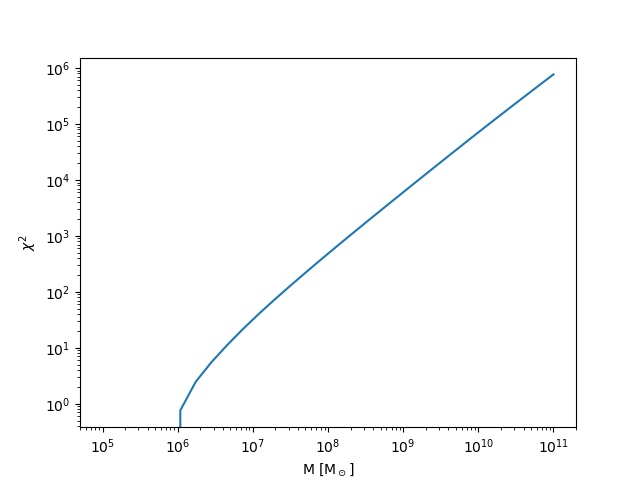

Text(0,0.5,'$\\chi^2$')

In [12]:
plt.subplots()
plt.plot(10**log_M_arr, chi2_arr)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('M [M$_\odot$]')
plt.ylabel('$\chi^2$')

In [13]:
scan.analyze(res_arr, [1,2,3,4,5,10])
# this will generate 1, 2, 3, 4, 5, 10 sigmas 
# and save it into result.M_contours

<IPython.core.display.Javascript object>


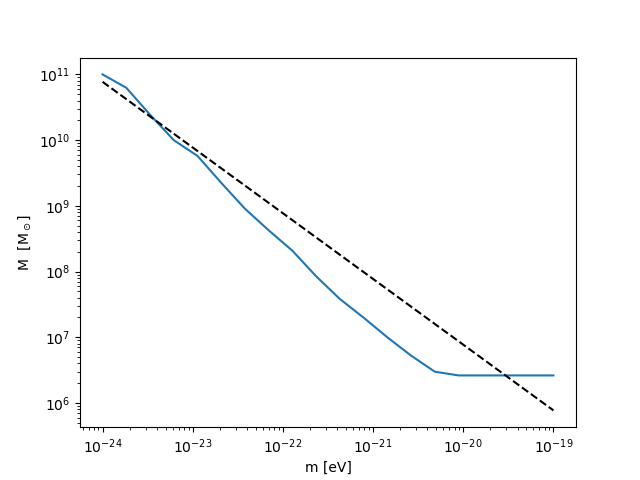

Text(0,0.5,'M  [M$_\\odot$]')

In [15]:
plt.subplots()

m_plt_arr = []
M_plt_arr = []
for result in res_arr:
    m = result.m
    M = result.M_contours[4]
    m_plt_arr.append(m)
    M_plt_arr.append(M)

# the bound
plt.plot(m_plt_arr, M_plt_arr)
# the SH prediction
Msol_SH_arr = model.M_SH(m_plt_arr, gal)
plt.plot(m_plt_arr, Msol_SH_arr, 'k--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M  [M$_\odot$]')

<IPython.core.display.Javascript object>


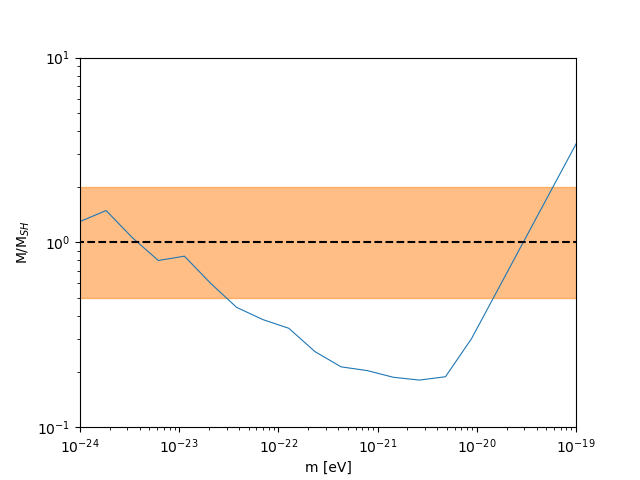

(1e-24, 1e-19)

In [16]:
# ratio plot

plt.subplots()

m_plt_arr = []
M_plt_arr = []
for result in res_arr:
    m = result.m
    M = result.M_contours[4]
    m_plt_arr.append(m)
    M_plt_arr.append(M)

# the bound
Msol_SH_arr = model.M_SH(m_plt_arr, gal)
plt.plot(m_plt_arr, M_plt_arr/ Msol_SH_arr, lw='0.8')

# the SH prediction
x = np.logspace(-25, -18)
y = [1] * 50
ylow = [0.5] * 50
yup = [2] * 50
plt.fill_between(x, ylow, yup, alpha=0.5, color='C1')
plt.plot(x, y, 'k--')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.1, 10)
plt.xlim(1e-24, 1e-19)

In [64]:
# save instance to file
uid = np.random.randint(1e10)
path = '../results/result-%d.dat' %uid

with open(path, 'w') as f:
    pickle.dump(result, f)

##load with
# with open(path, 'r') as f:
#     result2 = pickle.load(f)

# Scan on one galaxy - with scan.py

In [17]:
# packaged everything into scan.scan() 
scanner = scan.Scanner()
scanner.scan(gal, 
          num_of_ups=20, 
          num_of_log_M=20, 
          num_of_log_m=5, 
          dir_name='results_test3')

100%|██████████| 5/5 [00:25<00:00,  5.14s/it]


In [ ]:
# load and plot out

<IPython.core.display.Javascript object>


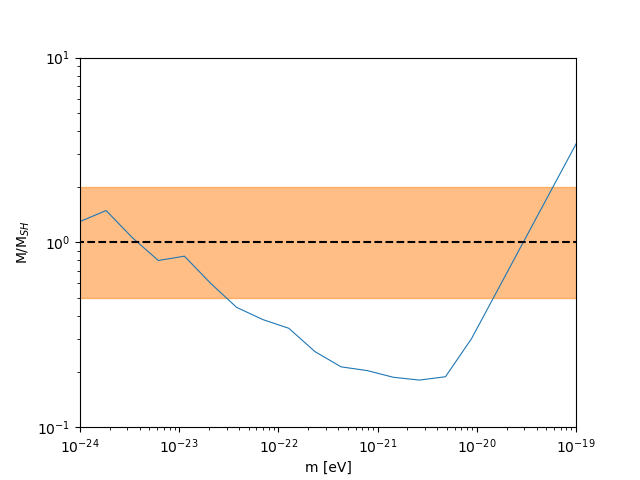

In [20]:
plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.1, 10)
plt.xlim(1e-24, 1e-19)

path_wild = '../results_test3/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        result= pickle.load(f)      
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            m = result.m
            M = result.M_contours[4]
            m_plt_arr.append(m)
            M_plt_arr.append(M)

        # the bound
        Msol_SH_arr = model.M_SH(m_plt_arr, gal)
        plt.plot(m_plt_arr, M_plt_arr/ Msol_SH_arr, lw='0.8')

        # the SH prediction
        x = np.logspace(-25, -18)
        y = [1] * 50
        ylow = [0.5] * 50
        yup = [2] * 50
        plt.fill_between(x, ylow, yup, alpha=0.5, color='C1')
        plt.plot(x, y, 'k--')


# Scan on all SPARC - from scan.py

In [10]:
os.getcwd()

'/tomerv2/cs/BEC_dynamics/submit/notebooks'

In [9]:
scanner = scan.Scanner()

def f(gal):
    scanner.scan(gal, 
                 num_of_ups=50, #20
                 num_of_log_M=50, #20
                 num_of_log_m=50, #20
                 dir_name='results_test11')

with closing(Pool()) as pool:
    pool.map(f, data)
    pool.terminate()


  2%|▏         | 1/50 [00:53<43:23, 53.13s/it]8s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [52]:
bound_dct = {}

<IPython.core.display.Javascript object>


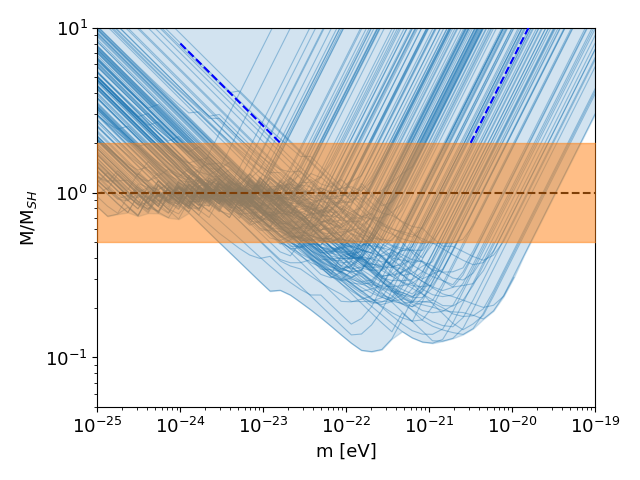

In [172]:
plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.05, 10)
#plt.xlim(2e-24, 1e-19)
plt.xlim(1e-25, 1e-19)

ratio_upper = 2
ratio_lower = 0.5

M_joint_arr = []
m_joint_arr = []
n_ind = 1

path_wild = '../../results_test11/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage
        scan.analyze(res_arr, res_arr[0].sigma_lvl)
        
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            if not result.sane:
                continue            
            m = result.m
            M = result.M_contours[n_ind]
            m_plt_arr.append(m)
            M_plt_arr.append(M)
        
        # the bound
        m_plt_arr = np.asarray(m_plt_arr)        
        Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
        ratio_arr = M_plt_arr/ Msol_SH_arr
        mask = ratio_arr < ratio_upper * 10
        plt.plot(m_plt_arr[mask], ratio_arr[mask], lw='0.8', color='C0', alpha=0.4)
        
        m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_arr, ratio_arr)

# the joint bound
plt.fill_between(m_plt_arr, M_joint_arr, 10, color='C0', alpha=0.2)
bound_dct[str(n_ind)] = (m_plt_arr, M_joint_arr)

# the SH prediction
x = np.logspace(-25, -18)
y = [1] * 50
ylow = [ratio_lower] * 50
yup = [ratio_upper] * 50
plt.fill_between(x, ylow, yup, alpha=0.5, color='C1', zorder=3)
plt.plot(x, y, 'k--')

m_test = np.logspace(-24, -22.8)
M_test = 8*(m_test/1e-24)**(-1/2)
plt.plot(m_test, M_test, 'b--', zorder=5)

m_test = np.logspace(-20.5, -19)
M_test = 2.*(m_test/m_test[0])
plt.plot(m_test, M_test, 'b--', zorder=5)

plt.rcParams.update({'font.size': 13})
plt.tight_layout()

plt.savefig('./plots/sol_full_SPARC_2sigma.pdf')

<IPython.core.display.Javascript object>


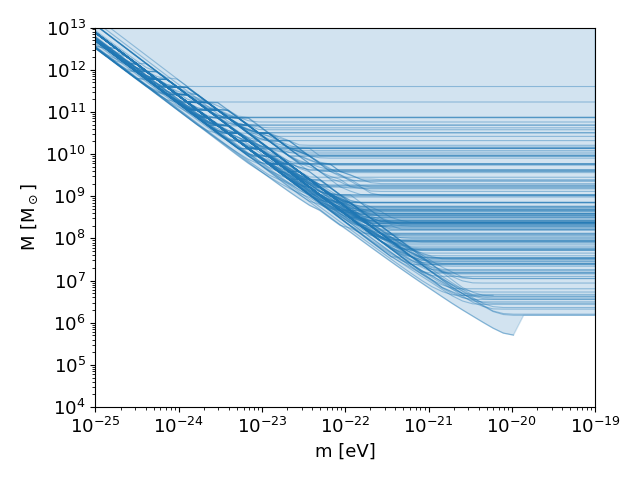

In [162]:
plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M [M$_\odot$]')
#plt.ylim(0.05, 10)
#plt.xlim(2e-24, 1e-19)
plt.ylim(1e4, 1e13)
plt.xlim(1e-25, 1e-19)

ratio_upper = 2
ratio_lower = 0.5

M_joint_arr = []
m_joint_arr = []
n_ind = 1

path_wild = '../../results_test11/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage
        scan.analyze(res_arr, res_arr[0].sigma_lvl)
        
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            if not result.sane:
                continue            
            m = result.m
            M = result.M_contours[n_ind]
            m_plt_arr.append(m)
            M_plt_arr.append(M)
        
        # the bound
        m_plt_arr = np.asarray(m_plt_arr)        
        Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
        ratio_arr = M_plt_arr/ Msol_SH_arr
        
        plt.plot(m_plt_arr, M_plt_arr, lw='0.8', color='C0', alpha=0.4)
        
        m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_arr, M_plt_arr)

# the joint bound
plt.fill_between(m_plt_arr, M_joint_arr, 1e20, color='C0', alpha=0.2)
#bound_dct[str(n_ind)] = (m_plt_arr, M_joint_arr)

# # the SH prediction
# x = np.logspace(-25, -18)
# y = [1] * 50
# ylow = [ratio_lower] * 50
# yup = [ratio_upper] * 50
# plt.fill_between(x, ylow, yup, alpha=0.5, color='C1', zorder=3)
# plt.plot(x, y, 'k--')

# m_test = np.logspace(-24, -22.8)
# M_test = 8*(m_test/1e-24)**(-1/2)
# plt.plot(m_test, M_test, 'b--', zorder=5)

# m_test = np.logspace(-20.5, -19)
# M_test = 2.*(m_test/m_test[0])
# plt.plot(m_test, M_test, 'b--', zorder=5)

plt.rcParams.update({'font.size': 13})
plt.tight_layout()

#plt.savefig('./plots/sol_full_SPARC_2sigma.pdf')

In [164]:
# get the sigma levels

path_wild = '../../results_test10/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage

        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:         
            sigma_lvl_arr = result.sigma_lvl    
            break
    break
    
# get sigma index
print('scan %s have the following sigma levels: %s' %(path_wild, sigma_lvl_arr))

scan ../../results_test10/* have the following sigma levels: [1, 2, 3, 4, 5, 10]


In [180]:
# the sigma indices need to really exist corresponding to result.sigma_lvl
for n_ind in [2,4,5]:
    
    M_joint_arr = []
    m_joint_arr = []

#     path_wild = '../../results_test10/*'
#     path_arr = glob.glob(path_wild)
    for path in path_arr:
        with open(path, 'r') as f:
            results= pickle.load(f)      
            res_arr = results.storage
            scan.analyze(res_arr, res_arr[0].sigma_lvl)                

            m_plt_arr = []
            M_plt_arr = []
            for result in res_arr:
                if not result.sane:
                    continue      
                
                m = result.m
                M = result.M_contours[n_ind]
                m_plt_arr.append(m)
                M_plt_arr.append(M)

            # the bound
            m_plt_arr = np.asarray(m_plt_arr)        
            Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
            ratio_arr = M_plt_arr/ Msol_SH_arr
            mask = ratio_arr < ratio_upper * 10
            m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_arr, ratio_arr)

    # the joint bound
    bound_dct[str(n_ind)] = (m_plt_arr, M_joint_arr)


<IPython.core.display.Javascript object>


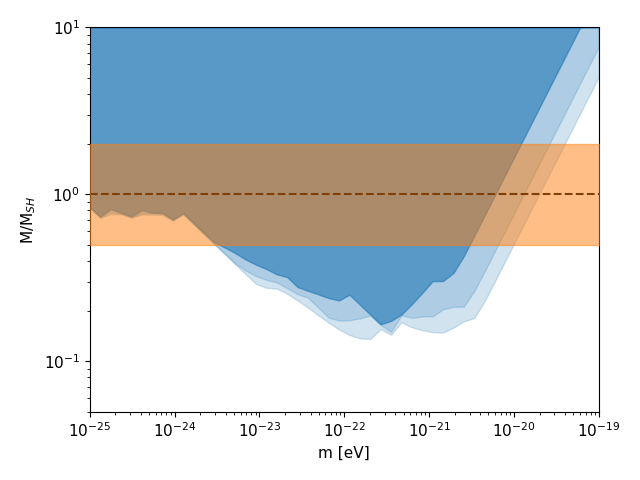

In [181]:
plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.05, 10)
plt.xlim(1e-25, 1e-19)

# 3sigma
(m, Mratio) = bound_dct['2']
plt.fill_between(m, Mratio, 10, alpha=0.2, color='C0')

# 5sigma
(m, Mratio) = bound_dct['4']
plt.fill_between(m, Mratio, 10, alpha=0.2, color='C0')

# 10sigma
(m, Mratio) = bound_dct['5']
plt.fill_between(m, Mratio, 10, alpha=0.6, color='C0')


# the SH prediction
x = np.logspace(-25, -18)
y = [1] * 50
ylow = [ratio_lower] * 50
yup = [ratio_upper] * 50
plt.fill_between(x, ylow, yup, alpha=0.5, color='C1', zorder=3)
plt.plot(x, y, 'k--')

plt.rcParams.update({'font.size': 13})
plt.tight_layout()

plt.savefig('./plots/sol_full_SPARC_combine.pdf')

<IPython.core.display.Javascript object>


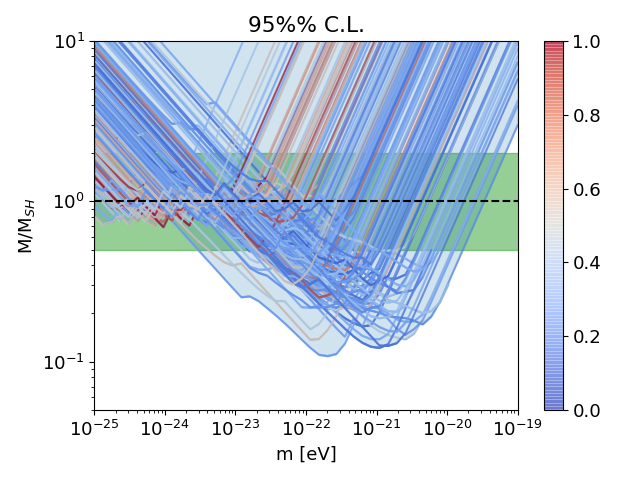

In [176]:
_, ax = plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.05, 10)
plt.xlim(1e-25, 1e-19)

ratio_upper = 2
ratio_lower = 0.5
f_cut = 1

M_joint_arr = []
m_joint_arr = []
n_ind = 1

path_wild = '../../results_test10/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage
        scan.analyze(res_arr, res_arr[0].sigma_lvl)        
        
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            if not result.sane:
                continue            
            m = result.m
            M = result.M_contours[n_ind]
            m_plt_arr.append(m)
            M_plt_arr.append(M)
        
        # the bound
        m_plt_arr = np.asarray(m_plt_arr)        
        Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
        ratio_arr = M_plt_arr/ Msol_SH_arr
        mask = ratio_arr < ratio_upper * 10
        m_plt_finer_arr = np.logspace(np.log10(m_plt_arr[0]), np.log10(m_plt_arr[-1]), 1000)
        ratio_finer_arr = np.exp(np.interp(np.log(m_plt_finer_arr), 
                                           np.log(m_plt_arr), 
                                           np.log(ratio_arr)))
        M_plt_finer_arr = np.exp(np.interp(np.log(m_plt_finer_arr), 
                                           np.log(m_plt_arr), 
                                           np.log(M_plt_arr)))        
        fbar2DM =[]
        for i, mm in enumerate(m_plt_finer_arr):
            MMsol = M_plt_finer_arr[i]
            val = model.bar_ratio_at_peak(result.gal, MMsol)            
            val = min(val, 1)
            fbar2DM.append(val)
            if val > f_cut:
                ratio_finer_arr[i] = 100
        fbar2DM[0] = 0
        fbar2DM[1] = 1
        sc = plt.scatter(m_plt_finer_arr, ratio_finer_arr, s=0.4, c=(fbar2DM), cmap=cm.coolwarm, alpha=0.5)               
        m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_finer_arr, ratio_finer_arr)

        
plt.colorbar(sc)

# the joint bound
plt.fill_between(m_joint_arr, M_joint_arr, 10, color='C0', alpha=0.2)
bound_dct[str(n_ind)] = (m_plt_arr, M_joint_arr)

# the SH prediction
x = np.logspace(-25, -18)
y = [1] * 50
ylow = [ratio_lower] * 50
yup = [ratio_upper] * 50
plt.fill_between(x, ylow, yup, alpha=0.5, color='C2', zorder=0)
plt.plot(x, y, 'k--')
plt.title('95%% C.L.')

plt.rcParams.update({'font.size': 11})
plt.tight_layout()

plt.savefig('./plots/sol_full_SPARC_2sigma_cmap.pdf')

# Check rotation curves of galaxies

In [203]:
# find the top runners
M_joint_arr = []
m_joint_arr = []
#name_joint_arr = []
data_dct = {}
n_ind = 1 # 2sigmas

path_wild = '../../results_test10/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage

        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            if not result.sane:
                continue            
            m = result.m
            M = result.M_contours[n_ind]
            m_plt_arr.append(m)
            M_plt_arr.append(M)
            try:
                data_dct[str(m)]
            except KeyError:
                data_dct[str(m)] = []
            data_dct[str(m)].append((M, result.gal.name))

In [251]:
# find top few in each m slice
rank_dct = {}
top_runner_arr = []
output_arr = [] # the log array

for key in data_dct.keys():
    rank_dct[key] = sorted(data_dct[key], key=lambda x:float(x[0]))
    top_n = 2
    # list of tuples to 2D array
    names_arr = np.array(rank_dct[key][:top_n])
    #print('m=%.1e has a bound of %.1e Msun from %s' %(float(key), float(names_arr[0,0]), names_arr[0,1]))
    output_str = 'm=%.1e has a bound of %.1e Msun from %s' %(float(key), float(names_arr[0,0]), names_arr[0,1])
    output_arr.append((float(key), output_str))
    # only save names
    names_arr = names_arr[:,1]
    top_runner_arr.append(names_arr)

top_runner_arr = np.array(top_runner_arr)
# get unique
top_runner_arr = np.unique(top_runner_arr.reshape(-1))

In [262]:
output_arr = np.array(sorted(output_arr, key=lambda x:float(x[0])))
for x in output_arr:
    print(x[1])

m=1.0e-25 has a bound of 2.2e+12 Msun from UGC09133
m=1.3e-25 has a bound of 1.5e+12 Msun from UGC00128
m=1.8e-25 has a bound of 9.5e+11 Msun from UGC00128
m=2.3e-25 has a bound of 6.3e+11 Msun from UGC00128
m=3.1e-25 has a bound of 4.1e+11 Msun from UGC00128
m=4.1e-25 has a bound of 2.7e+11 Msun from UGC00128
m=5.4e-25 has a bound of 1.8e+11 Msun from UGC07125
m=7.2e-25 has a bound of 1.2e+11 Msun from UGC07125
m=9.5e-25 has a bound of 7.9e+10 Msun from UGC07125
m=1.3e-24 has a bound of 5.4e+10 Msun from UGC07125
m=1.7e-24 has a bound of 4.0e+10 Msun from F563-V1
m=2.2e-24 has a bound of 2.7e+10 Msun from F563-V1
m=2.9e-24 has a bound of 1.8e+10 Msun from F563-V1
m=3.9e-24 has a bound of 1.2e+10 Msun from F563-V1
m=5.2e-24 has a bound of 8.5e+09 Msun from F563-V1
m=6.9e-24 has a bound of 6.0e+09 Msun from F563-V1
m=9.1e-24 has a bound of 3.9e+09 Msun from PGC51017
m=1.2e-23 has a bound of 2.6e+09 Msun from PGC51017
m=1.6e-23 has a bound of 1.7e+09 Msun from PGC51017
m=2.1e-23 has a bo

In [257]:
top_runner_arr

array(['CamB', 'D631-7', 'DDO161', 'F563-V1', 'IC2574', 'KK98-251',
       'NGC0289', 'PGC51017', 'UGC00128', 'UGC01281', 'UGC04305',
       'UGC04483', 'UGC07125', 'UGC09133'], dtype='|S32')

# check single galaxy

Check bounds from specific galaxy

In [19]:
# Redo the contour finding

In [146]:
result = results.storage[2]

# chi2_to_interp_arr = np.concatenate(
#     ([result.chi2_arr[np.logical_not(mask)][-1]], result.chi2_arr[mask]))

chi2_to_interp_arr = np.concatenate(
    ([1e-10], result.chi2_arr[mask]))

M_to_interp_arr = np.concatenate(
    ([result.M_arr[np.logical_not(mask)][-1]], result.M_arr[mask]))


<IPython.core.display.Javascript object>


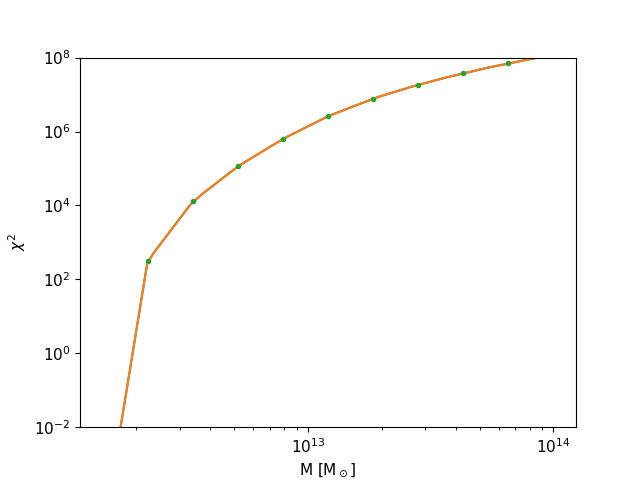

(0.01, 100000000.0)

In [179]:
y_arr = np.logspace(-5, 8)
#x_interp1d_arr = 10**interp1d(result.chi2_arr[mask], np.log10(result.M_arr[mask]))(y_arr)
# x_interp_arr = 10**np.interp(y_arr, result.chi2_arr[mask], np.log10(result.M_arr[mask]))
x_interp1d_arr = 10**interp1d(np.log10(chi2_to_interp_arr), np.log10(M_to_interp_arr), kind='linear')(np.log10(y_arr))
x_interp_arr = 10**np.interp(np.log10(y_arr), np.log10(chi2_to_interp_arr), np.log10(M_to_interp_arr))

plt.subplots()
plt.plot(x_interp1d_arr, y_arr)
plt.plot(x_interp_arr, y_arr)

plt.plot(M_to_interp_arr, chi2_to_interp_arr, '.')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(-1, 10)
#plt.xlim(1e12, 2e12)
plt.ylabel('$\chi^2$')
plt.xlabel('M [M$_\odot$]')
plt.ylim(1e-2, 1e8)

<IPython.core.display.Javascript object>


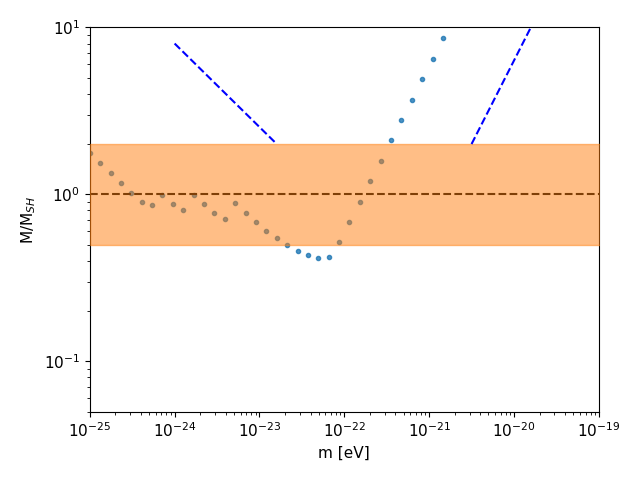

In [170]:
#name_arr = ['UGC07125', 'UGC09133', 'UGC00128']
name_arr = ['UGC00128']

plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.05, 10)
#plt.xlim(2e-24, 1e-19)
plt.xlim(1e-25, 1e-19)

ratio_upper = 2
ratio_lower = 0.5

M_joint_arr = []
m_joint_arr = []
n_ind = 1

path_wild = '../../results_test11/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)             
        res_arr = results.storage
        
        # customize analyze here
        scan.analyze(res_arr, res_arr[0].sigma_lvl)
        
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            if not(result.gal.name in name_arr):
                continue
            if not result.sane:
                continue            
            m = result.m
            M = result.M_contours[n_ind]
            m_plt_arr.append(m)
            M_plt_arr.append(M)
            
        
        # the bound
        m_plt_arr = np.asarray(m_plt_arr)        
        Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
        ratio_arr = M_plt_arr/ Msol_SH_arr
        mask = ratio_arr < ratio_upper * 10
        plt.plot(m_plt_arr[mask], ratio_arr[mask], '.', lw='0.8', color='C0', alpha=0.8)
        
        m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_arr, ratio_arr)

# # the joint bound
# plt.fill_between(m_plt_arr, M_joint_arr, 10, color='C0', alpha=0.2)

# the SH prediction
x = np.logspace(-25, -18)
y = [1] * 50
ylow = [ratio_lower] * 50
yup = [ratio_upper] * 50
plt.fill_between(x, ylow, yup, alpha=0.5, color='C1', zorder=3)
plt.plot(x, y, 'k--')

m_test = np.logspace(-24, -22.8)
M_test = 8*(m_test/1e-24)**(-1/2)
plt.plot(m_test, M_test, 'b--', zorder=5)

m_test = np.logspace(-20.5, -19)
M_test = 2.*(m_test/m_test[0])
plt.plot(m_test, M_test, 'b--', zorder=5)

plt.rcParams.update({'font.size': 13})
plt.tight_layout()



<IPython.core.display.Javascript object>


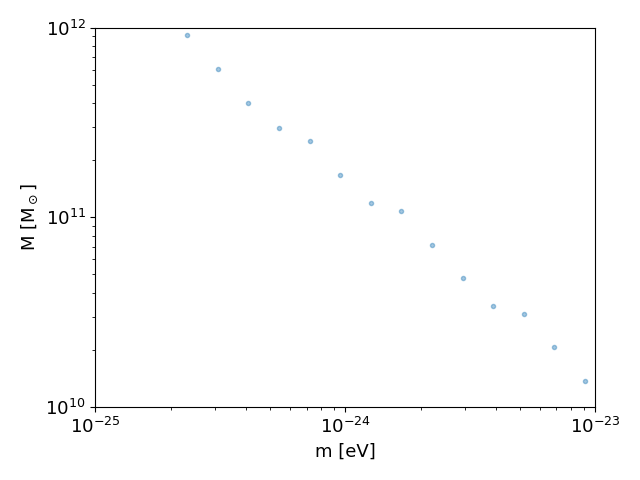

In [182]:
plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M [M$_\odot$]')
#plt.ylim(0.05, 10)
#plt.xlim(2e-24, 1e-19)
plt.ylim(1e10, 1e12)
plt.xlim(1e-25, 1e-23)

ratio_upper = 2
ratio_lower = 0.5

M_joint_arr = []
m_joint_arr = []
n_ind = 1

path_wild = '../../results_test11/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage
        scan.analyze(res_arr, res_arr[0].sigma_lvl)        
        
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            if not(result.gal.name in name_arr):
                continue
            if not result.sane:
                continue            
            m = result.m
            M = result.M_contours[n_ind]
            m_plt_arr.append(m)
            M_plt_arr.append(M)
        
        # the bound
        m_plt_arr = np.asarray(m_plt_arr)        
        Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
        ratio_arr = M_plt_arr/ Msol_SH_arr
        
        plt.plot(m_plt_arr, M_plt_arr, '.', lw='0.8', color='C0', alpha=0.4)
        
        m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_arr, M_plt_arr)

# the joint bound
#plt.fill_between(m_plt_arr, M_joint_arr, 1e20, color='C0', alpha=0.2)

plt.rcParams.update({'font.size': 13})
plt.tight_layout()

#plt.savefig('./plots/sol_full_SPARC_2sigma.pdf')

In [263]:
# plot out the rot curves

<IPython.core.display.Javascript object>


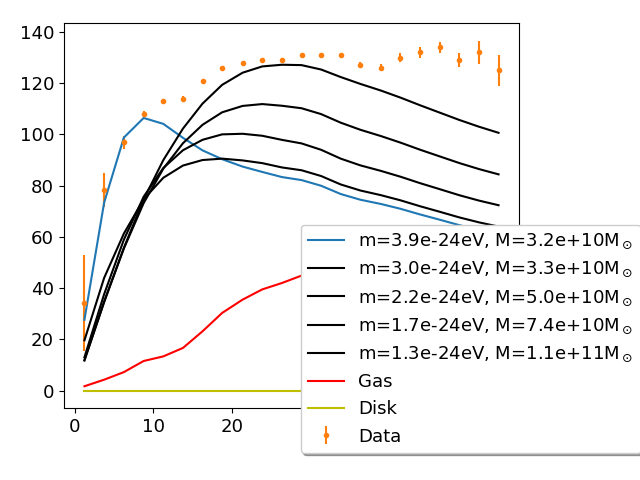

0.5986492339679107
0
0
0
0


In [16]:
gal = spc.findGalaxyByName('UGC00128', data)
plt.subplots()

DM_profile = 'Burkert'


m = 3.948e-24
M = 3.17*10**10
ups_bulg = 0.
ups_disk = 0.
c = 0.
Rs = 0.1

chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
                                      flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
print(chi2_val)
plt.plot(gal.R, Vtot, '-', label='m=%.1eeV, M=%.1eM$_\odot$' %(m,M))


m = 2.95e-24
M = 3.28*10**10
ups_bulg = 0.263
ups_disk = 0.263
c = 0.
Rs = 0.1

chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
                                      flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
print(chi2_val)
plt.plot(gal.R, Vtot, 'k-', label='m=%.1eeV, M=%.1eM$_\odot$' %(m,M))



m = 2.24e-24
M = 5.04*10**10
ups_bulg = 0.
ups_disk = 0.
c = 0.
Rs = 0.1

chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
                                      flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
print(chi2_val)
plt.plot(gal.R, Vtot, 'k-',  label='m=%.1eeV, M=%.1eM$_\odot$' %(m,M))



m = 1.68e-24
M = 7.41*10**10
ups_bulg = 0.
ups_disk = 0.
c = 0.
Rs = 0.1

chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
                                      flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
print(chi2_val)
plt.plot(gal.R, Vtot, 'k-',  label='m=%.1eeV, M=%.1eM$_\odot$' %(m,M))



m = 1.27e-24
M = 1.12*10**11
ups_bulg = 0.
ups_disk = 0.
c = 0.
Rs = 0.1

chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
                                      flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
print(chi2_val)
plt.plot(gal.R, Vtot, 'k-',  label='m=%.1eeV, M=%.1eM$_\odot$' %(m,M))



# m = 1e-24
# M = 1.35*10**11
# ups_bulg = 0.8
# ups_disk = 0.8
# c = 0.
# Rs = 0.1

# chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
#                                       flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
# print(chi2_val)
# plt.plot(gal.R, Vtot, 'k-', label='Vtot')




# m = 5.4e-25
# M = 2.7*10**11
# ups_bulg = 0.8
# ups_disk = 0.8
# c = 0.
# Rs = 0.1

# chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
#                                       flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
# print(chi2_val)
# plt.plot(gal.R, Vtot, 'k-', label='Vtot')





# m = 4.12e-25
# M = 3.6*10**11
# ups_bulg = 0.8
# ups_disk = 0.8
# c = 0.
# Rs = 0.1

# chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
#                                       flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
# print(chi2_val)
# plt.plot(gal.R, Vtot, 'k-', label='Vtot')




# m = 3.06e-25
# M = 4.27*10**11
# ups_bulg = 0.8
# ups_disk = 0.8
# c = 0.
# Rs = 0.1

# chi2_val, Vtot = chi2.chi2_single_gal(m, M, c, Rs, ups_disk, ups_bulg, gal, 
#                                       flg_Vtot=True, DM_profile=DM_profile, flg_overshoot=True)
# print(chi2_val)
# plt.plot(gal.R, Vtot, 'k-', label='Vtot')



plt.errorbar(gal.R, gal.Vobs, gal.dVobs, fmt='.', label='Data')
plt.plot(gal.R, gal.Vgas,'r-', label='Gas')
plt.plot(gal.R, np.sqrt(ups_disk)*gal.Vdisk,'y-', label='Disk')

#plt.legend(loc='best')
plt.legend(bbox_to_anchor=(0.5, 0.5), ncol=1, fancybox=True, shadow=True)
plt.tight_layout()

# Translate to DM fraction

<IPython.core.display.Javascript object>


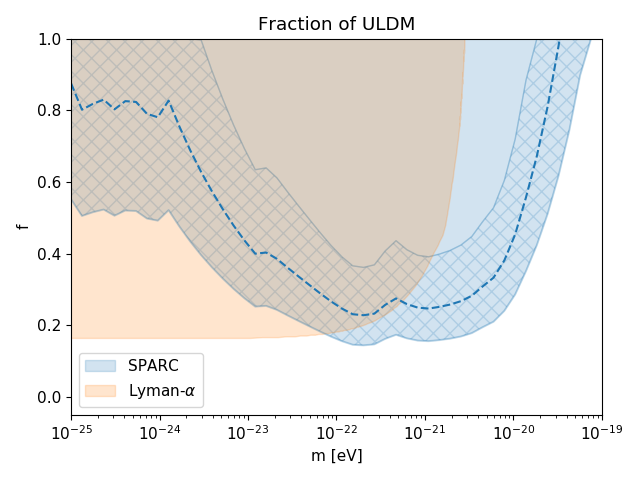

In [177]:
plt.subplots()
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('f')
plt.title('Fraction of ULDM')
plt.ylim(-0.05, 1)
#plt.xlim(2e-24, 1e-19)
plt.xlim(1e-25, 1e-19)

ratio_upper = 2
ratio_lower = 0.5

M_joint_arr = []
m_joint_arr = []
n_ind = 1

path_wild = '../../results_test10/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage
        scan.analyze(res_arr, res_arr[0].sigma_lvl)        
        
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            if not result.sane:
                continue            
            m = result.m
            M = result.M_contours[n_ind]
            m_plt_arr.append(m)
            M_plt_arr.append(M)
        
        # the bound
        m_plt_arr = np.asarray(m_plt_arr)        
        Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
        ratio_arr = M_plt_arr/ Msol_SH_arr
        
        m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_arr, ratio_arr)
        
# the joint bound

x = m_plt_arr
y = M_joint_arr**(2./3)
#mask = y < 1
#plt.plot(x[mask], y[mask], color='C0', ls='--')
plt.plot(x, y, color='C0', ls='--')

yupper = (2. *M_joint_arr)**(2./3)
ylower = (0.5*M_joint_arr)**(2./3)
yupper[yupper>1] = 1.
ylower[ylower>1] = 1.

plt.fill_between(m_plt_arr, ylower, yupper, color='C0', alpha=0.2, hatch="xx")
plt.fill_between(m_plt_arr, yupper, 100, color='C0', alpha=0.2, label='SPARC')
plt.plot(m_plt_arr, ylower, color='C0', alpha=0.2)

# overlay with Kobayashi
path = '../data/Kobayashi2017.csv'
data_lym_arr = np.loadtxt(path, delimiter=',')
x = data_lym_arr[:,0]
y = data_lym_arr[:,1]
x = np.insert(x, 0, 1e-25)
y = np.insert(y, 0, y[0])
plt.fill_between(x, y, 100, color='C1', label=r'Lyman-$\alpha$', alpha=0.2)
plt.legend(loc=3)
plt.tight_layout()

plt.savefig('./plots/f_2sigma.pdf')